This notebook contains the code to create Figures 1D and 3 from the main text as well as Figures S3, S4, S5 and S9 from the Supplementary Information. It uses Python 3.8.10 and the packages SciPy (version 1.8.0), NumPy (version 1.17.4) and Matplotlib (version 3.1.2)

In [1]:
import math as m
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def model(t,x):  # full model: two consumers, plastic dispersal
    Nx = x[0]
    Ny = x[1]
    Ax = x[2]
    Ay = x[3]
    Sx = x[4]
    Sy = x[5]
    Ix = x[6]
    Iy = x[7]
    
    a_crit_S = D/(aS*(e-h*D))
    a_crit_I = D/(aI*(e-h*D))
    
    dSx = dSmax/(1+m.exp(kS*(Ax - a_crit_S)))
    dSy = dSmax/(1+m.exp(kS*(Ay - a_crit_S)))
    
    dIx = dImax/(1+m.exp(kI*(Ax - a_crit_I)))
    dIy = dImax/(1+m.exp(kI*(Ay - a_crit_I)))
    
    rx = rmax*Nx/(Nh+Nx)
    ry = rmax*Ny/(Nh+Ny)
    
    gSx = aS*Ax/(1+aS*h*Ax)
    gSy = aS*Ay/(1+aS*h*Ay)
    
    gIx = aI*Ax/(1+aI*h*Ax)
    gIy = aI*Ay/(1+aI*h*Ay)
        
    Nxdot = D*(S-Nx) - rx*Ax + dN*(Ny-Nx)
    Nydot = D*(S-Ny) - ry*Ay + dN*(Nx-Ny)
    
    Axdot = rx*Ax - gSx*Sx - gIx*Ix - D*Ax + dA*(Ay-Ax)
    Aydot = ry*Ay - gSy*Sy - gIy*Iy - D*Ay + dA*(Ax-Ay)
    
    Sxdot = (e*gSx*Sx - D*Sx - dSx*Sx + dSy*Sy)*switch  # switch needed for numerical reasons is H_S is the
    Sydot = (e*gSy*Sy - D*Sy - dSy*Sy + dSx*Sx)*switch  # invader (then, intially switch = 0, else switch = 1)
    
    Ixdot = e*gIx*Ix - D*Ix - dIx*Ix + dIy*Iy
    Iydot = e*gIy*Iy - D*Iy - dIy*Iy + dIx*Ix
    
    return [Nxdot,Nydot,Axdot,Aydot,Sxdot,Sydot,Ixdot,Iydot]

def model_onepatch(t,x):  # one patch, i.e., no dispersal, no inferior consumer
    N = x[0]
    A = x[1]
    H = x[2]
    
    r = rmax*N/(Nh+N)
    gH = aS*A/(1+aS*h*A)
        
    Ndot = D*(S-N) - r*A 
    Adot = r*A - gH*H - D*A 
    Hdot = e*gH*H - D*H 
    
    return [Ndot,Adot,Hdot]    

def model_static_env_het(t,x):  # static environmental heterogeneity (no nutrient diffusion, Seff_x != Seff_y)
    Nx = x[0]
    Ny = x[1]
    Ax = x[2]
    Ay = x[3]
    Sx = x[4]
    Sy = x[5]
    Ix = x[6]
    Iy = x[7]
    
    a_crit_S = D/(aS*(e-h*D))
    a_crit_I = D/(aI*(e-h*D))
    
    dSx = dSmax*(1 - 1/(1+m.exp(kS*(a_crit_S - Ax))))
    dSy = dSmax*(1 - 1/(1+m.exp(kS*(a_crit_S - Ay))))
    
    dIx = dImax*(1 - 1/(1+m.exp(kI*(a_crit_I - Ax))))
    dIy = dImax*(1 - 1/(1+m.exp(kI*(a_crit_I - Ay))))
    
    rx = rmax*Nx/(Nh+Nx)
    ry = rmax*Ny/(Nh+Ny)
    
    gSx = aS*Ax/(1+aS*h*Ax)
    gSy = aS*Ay/(1+aS*h*Ay)
    
    gIx = aI*Ax/(1+aI*h*Ax)
    gIy = aI*Ay/(1+aI*h*Ay)
        
    Nxdot = D*(Seff_x-Nx) - rx*Ax 
    Nydot = D*(Seff_y-Ny) - ry*Ay 
    
    Axdot = rx*Ax - gSx*Sx - gIx*Ix - D*Ax + dA*(Ay-Ax)
    Aydot = ry*Ay - gSy*Sy - gIy*Iy - D*Ay + dA*(Ax-Ay)
    
    Sxdot = e*gSx*Sx - D*Sx - dSx*Sx + dSy*Sy
    Sydot = e*gSy*Sy - D*Sy - dSy*Sy + dSx*Sx
    
    Ixdot = e*gIx*Ix - D*Ix - dIx*Ix + dIy*Iy
    Iydot = e*gIy*Iy - D*Iy - dIy*Iy + dIx*Ix
    
    return [Nxdot,Nydot,Axdot,Aydot,Sxdot,Sydot,Ixdot,Iydot]


In [3]:
# standard parameters
S = 4.8
D = 0.3
Nh = 1.5
rmax = 0.7
h = 0.53
e = 0.33
aS = 1.2
aI = 1.0
kS = 0
kI = 0
dN = 1
dA = 0.001
dSmax = 0.2 # no Turing instability
dImax = 0.03

switch = 1 


t = np.linspace(0, 10000, 10000)
#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.2,0.2,0.1,0.1]


## Fig. 1D: heatmap time series $\times$ $d_{max,H}$

In [4]:
Lt = 1000  # length of time series and values of dS 
LS = 1000

tt = np.linspace(0, 500, Lt)

# first get the stable fixed point to obtain uniform starting conditions close to it
dSmax = 0.1
x0 = [1.7,2.2,3,1,0.2,0.2,0.,0.] # initial starting conditions, values are quite irrelevant 
X = odeint(model, x0, tt,tfirst=True)  # integrate the differential equation

x0 = X[-1]*[1.,1.,1.05,0.95,1,1,1,1] # starting conditions close to the fixed point

dSmax_vals = np.logspace(-3,1,LS)
x_vals = np.zeros((Lt,LS))

i = 0
for dSmax in dSmax_vals:
    X = odeint(model, x0, tt,tfirst=True)
    x_vals[i] = X[:,2]-X[:,3]
    i += 1

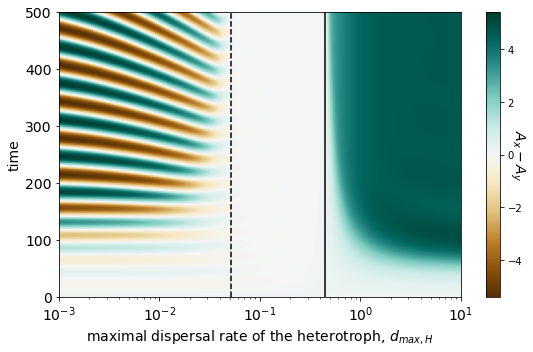

In [5]:
fig, ax = plt.subplots(figsize=(8,5))

im = plt.pcolor(dSmax_vals,tt,np.transpose(x_vals), cmap='BrBG') #BrBG
plt.vlines(0.0518,0,500,linestyle='dashed')
plt.vlines(0.441,0,500,linestyle='solid')

ax.set_xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"maximal dispersal rate of the heterotroph, $d_{max,H}$",fontsize=14)
plt.ylabel("time",fontsize=14)

cb = plt.colorbar(im,ax=ax)
cb.set_label(label=r"$A_x - A_y$", size=14,rotation=270)

plt.tight_layout()

plt.savefig("Figure_1D.png",dpi=300)

## Fig. 3: exemplary time series showing the coexistence mechanisms

In [6]:
# A: bet-hedging (standard) - BH
kS = 0
kI = 0
dSmax = 0.01
dImax = 0.1

x0 = [3.2,3.2,3,1,0.2,0.2,0.05,0.05]

X_BH = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

# B: maladaptive dispersal (standard) - MD
kS = 0
kI = 0
dSmax = 0.6
dImax = 0.2

x0 = [1.7,2.2,3,1,0.2,0.2,0.1,0.1]

X_MD = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

net_disp_Sx_MD = dSmax*(X_MD[:,5]-X_MD[:,4])  # net dispersal rates of S and I between the patches
net_disp_Ix_MD = dImax*(X_MD[:,7]-X_MD[:,6])

w_S = -200*net_disp_Sx_MD[-1]                 # width of arrows depicting neet dispersal flow
w_I = -200*net_disp_Ix_MD[-1]

# C: bet-hedging with heterogeneity-modulation - BM
kS = 0
kI = 2
dSmax = 0.01
dImax = 0.2

x0 = [1.7,2.2,3,1,0.2,0.2,0.1,0.1]

X_BM = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

# D: maladaptive dispersal with heterogeneity-modulation - MM
kS = 0
kI = 0
dSmax = 2
dImax = 0.2

x0 = [1.7,2.2,3,1,0.3,0.2,0.01,0.01]

X_MM = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

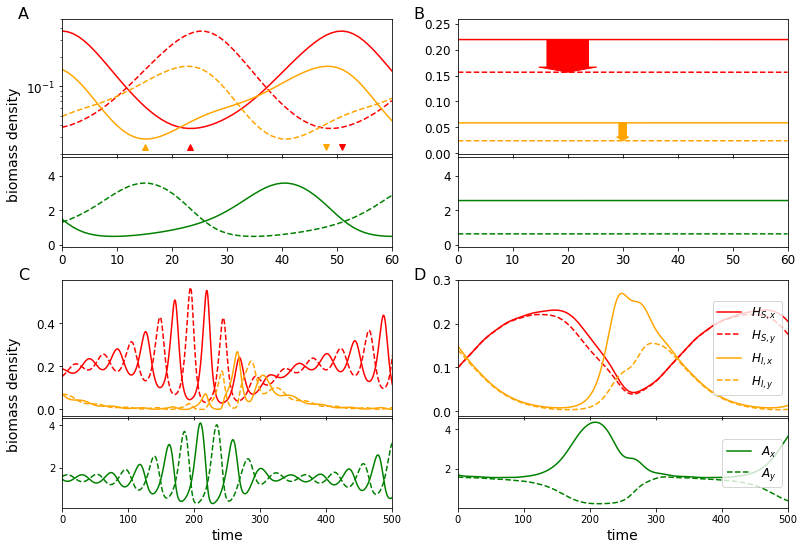

In [7]:
# first some settings for the grid to which the plots are aligned
x = 3
space = 2

hC = 3*x
hA = 2*x

y_Cons_A = 0
y_Auto_A = y_Cons_A + hC

y_Cons_C = y_Auto_A + hA + space
y_Auto_C = y_Cons_C + hC

total_y = 2*hC + 2*hA + space

# now the actual plot

plt.figure(figsize=(13,9))

# A

plt.subplot2grid((total_y,2),(y_Auto_A,0),rowspan=hA)

plt.plot(t-9940,X_BH[:,2],'g-',label=r'$A_x$')
plt.plot(t-9940,X_BH[:,3],'g--',label=r'$A_y$')

plt.ylim(-0.1,5.1)
plt.xlim(0,60)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = plt.subplot2grid((total_y,2),(y_Cons_A,0),rowspan=hC)
ax.axes.xaxis.set_ticklabels([])

plt.semilogy(t-9940,X_BH[:,4],'r-',label=r'$S_x$')
plt.semilogy(t-9940,X_BH[:,5],'r--',label=r'$S_y$')
plt.semilogy(t-9940,X_BH[:,6],'-',color='orange',label=r'$I_x$')
plt.semilogy(t-9940,X_BH[:,7],'--',color='orange',label=r'$I_y$')

plt.plot(15,0.024,"^",color="orange")
plt.plot(23.3,0.024,"^",color="red")
plt.plot(48,0.024,"v",color="orange")
plt.plot(51,0.024,"v",color="red")

plt.ylim(0.02,0.5)
plt.xlim(0,60)

plt.text(-10, 0.007, 'biomass density',  rotation='vertical',fontsize=14)
plt.text(-8, 0.5, 'A', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# B

plt.subplot2grid((total_y,2),(y_Auto_A,1),rowspan=hA)

plt.plot(t-9940,X_MD[:,2],'g-',label=r'$A_x$')
plt.plot(t-9940,X_MD[:,3],'g--',label=r'$A_y$')

plt.ylim(-0.1,5.1)
plt.xlim(0,60)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = plt.subplot2grid((total_y,2),(y_Cons_A,1),rowspan=hC)
ax.axes.xaxis.set_ticklabels([])

plt.plot(t-9940,X_MD[:,4],'r-',label=r'$S_x$')
plt.plot(t-9940,X_MD[:,5],'r--',label=r'$S_y$')
plt.plot(t-9940,X_MD[:,6],'-',color='orange',label=r'$I_x$')
plt.plot(t-9940,X_MD[:,7],'--',color='orange',label=r'$I_y$')

plt.arrow(20,X_MD[-1,4],0,X_MD[-1,5]-X_MD[-1,4],width = w_S,head_length = 0.01,head_width= 1.4*w_S,length_includes_head=True,color='r')
plt.arrow(30,X_MD[-1,6],0,X_MD[-1,7]-X_MD[-1,6],width = w_I,head_length = 0.0075,head_width= 1.6*w_I,length_includes_head=True,color='orange')

plt.text(-8, 0.26, 'B', fontsize=16)

plt.ylim(-0.002,0.26)
plt.xlim(0,60)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# C

plt.subplot2grid((total_y,2),(y_Auto_C,0),rowspan=hA)

plt.plot(t-9000,X_BM[:,2],'g-',label=r'$A_x$')
plt.plot(t-9000,X_BM[:,3],'g--',label=r'$A_y$')

plt.xlim(0,500)
plt.xlabel("time",fontsize=14)

ax = plt.subplot2grid((total_y,2),(y_Cons_C,0),rowspan=hC)
ax.axes.xaxis.set_ticklabels([])

plt.plot(t-9000,X_BM[:,4],'r-',label=r'$S_x$')
plt.plot(t-9000,X_BM[:,5],'r--',label=r'$S_y$')
plt.plot(t-9000,X_BM[:,6],'-',color='orange',label=r'$I_x$')
plt.plot(t-9000,X_BM[:,7],'--',color='orange',label=r'$I_y$')

plt.text(-10*50/6, -0.18, 'biomass density',  rotation='vertical',fontsize=14)
plt.text(-8*50/6, 0.6, 'C', fontsize=16)

plt.xlim(0,500)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# D

plt.subplot2grid((total_y,2),(y_Auto_C,1),rowspan=hA)

plt.plot(t-9100,X_MM[:,2],'g-',label=r'$A_x$')
plt.plot(t-9100,X_MM[:,3],'g--',label=r'$A_y$')

plt.xlim(0,500)
plt.xlabel("time",fontsize=14)

plt.legend(fontsize=12,loc = 5)


ax = plt.subplot2grid((total_y,2),(y_Cons_C,1),rowspan=hC)
ax.axes.xaxis.set_ticklabels([])

plt.plot(t-9100,X_MM[:,4],'r-',label=r'$H_{S,x}$')
plt.plot(t-9100,X_MM[:,5],'r--',label=r'$H_{S,y}$')
plt.plot(t-9100,X_MM[:,6],'-',color='orange',label=r'$H_{I,x}$')
plt.plot(t-9100,X_MM[:,7],'--',color='orange',label=r'$H_{I,y}$')

plt.ylim(-0.01,0.3)
plt.xlim(0,500)
plt.text(-8*50/6, 0.3, 'D', fontsize=16)

plt.legend(fontsize=12,loc = 5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("Figure_3.png",dpi=300)
plt.show()

## Fig. S3: invasion of $H_S$ in system with $H_I$ creating oscilatory or static Turing instability

In [8]:
aS = 1.2
aI = 1.0
kS = 0
kI = 0

# settings for H_I inducing oscillatory instability, H_S inducing no instability
dSmax = 0.1
dImax = 0.02

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.,0.,0.1,0.1]
X = odeint(model, x0, t,tfirst=True)  # integrate differential equation with only H_I present

x0 = X[-1] + [0,0,0,0,0.005,0.005,0,0]
Xo = odeint(model, x0, t,tfirst=True) 


# settings for H_I inducing static instability, H_S inducing no instability
switch = 0  # for numerical reasons: switch off dynamics for H_S during first phase
dImax = 0.6

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0,0,0.1,0.1]
X = odeint(model, x0, t,tfirst=True)  # integrate differential equation with only H_I present

switch = 1  # introduce H_S and switch its dynamics on again 
x0 = X[-1] + [0,0,0,0,0.0001,0.0001,0,0]
Xs = odeint(model, x0, t,tfirst=True) 

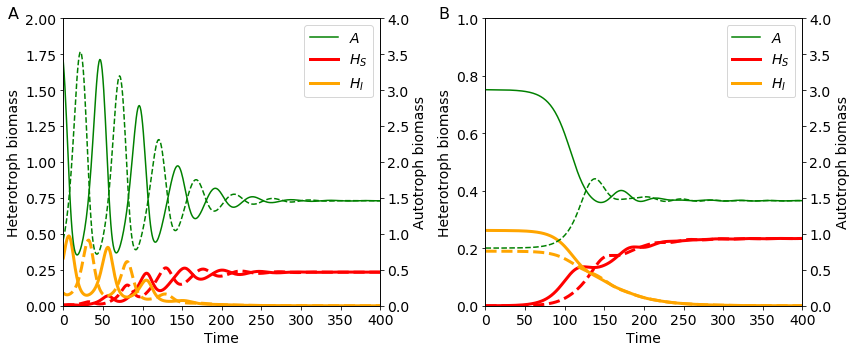

In [9]:
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot2grid((1,2),(0,0))

ax1.set_xlabel('Time', fontsize='14')
ax1.set_ylabel('Heterotroph biomass', fontsize='14')
ax1.set_xlim(0,400)
ax1.set_ylim(0,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=14)
ax2.plot(t,Xo[:,2],'g-')
ax2.plot(t,Xo[:,3],'g--')
ax2.set_ylim(0,4)
ax2.set_ylabel('Autotroph biomass', fontsize='14')  # we already handled the x-label with ax2

ax1.plot(t,Xo[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax1.plot(t,Xo[:,4],'r-',linewidth=3,label=r'$H_S$')
ax1.plot(t,Xo[:,5],'r--',linewidth=3)
ax1.plot(t,Xo[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax1.plot(t,Xo[:,7],'--',linewidth=3,color='orange')

ax1.legend(fontsize=14)
ax1.text(-70,2,'A',fontsize=16)


ax3 = plt.subplot2grid((1,2),(0,1))

ax3.set_xlabel('Time', fontsize='14')
ax3.set_ylabel('Heterotroph biomass', fontsize='14')
ax3.set_xlim(0,400)
ax3.set_ylim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=14)
ax4.plot(t,Xs[:,2],'g-')
ax4.plot(t,Xs[:,3],'g--')
ax4.set_ylim(0,4)
ax4.set_ylabel('Autotroph biomass', fontsize='14')  # we already handled the x-label with ax2

ax3.plot(t,Xs[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax3.plot(t,Xs[:,4],'r-',linewidth=3,label=r'$H_S$')
ax3.plot(t,Xs[:,5],'r--',linewidth=3)
ax3.plot(t,Xs[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax3.plot(t,Xs[:,7],'--',linewidth=3,color='orange')

ax3.legend(fontsize=14)
ax3.text(-60,1,'B',fontsize=16)

plt.tight_layout()
plt.savefig('Figure_S3.png',dpi=300)
plt.show();

## Fig. S4: Turing boundaries in system with one consumer

In [10]:
# homogeneous fixed point (= fixed point of the one-patch system)
def FP():
    #     N   A   S  
    x0 = [1.7,2.1,0.2]
    X = odeint(model_onepatch, x0, t,tfirst=True)  # integrate the differential equation
    
    return X[-1,0],X[-1,1],X[-1,2]

def local_Jacobian(N_star,A_star,S_star):
    t1 = 1/(Nh+N_star)
    t2 = 1/(1+aS*h*A_star)
    t3 = rmax*A_star*Nh*t1*t1
    t4 = rmax*N_star*t1
    t5 = aS*S_star*t2*t2
    t6 = aS*A_star*t2

    return np.array([[-D-t3,-t4,0],[t3,t4-D-t5,-t6],[0,e*t5,0]])

def diffusion_Jacobian(dN,dA,dSmax,kS):
    A_crit = D/(aS*(e-h*D))
    d1 = m.exp(kS*(A_star-A_crit))
    d2 = dSmax / (1+d1)
    d3 = d2*d1*S_star*kS / (1+d1)

    return np.array([[dN,0,0],[0,dA,0],[0,-d3,d2]]) 

# Turing matrix at the fixed point
def T_mat(dN,dA,dSmax,kS):

    J_mat = local_Jacobian(N_star,A_star,S_star)
    D_mat = diffusion_Jacobian(dN,dA,dSmax,kS)
    
    return J_mat - 2*D_mat    

# function that returns the coefficients of lambda**3 + b2*lambda**2 + b1*lambda + b0 = 0 
def coefs(dN,dA,dSmax,kS):
    a11, a12, a21 = T_mat(dN,dA,dSmax,kS)[0][0], T_mat(dN,dA,dSmax,kS)[0][1], T_mat(dN,dA,dSmax,kS)[1][0]
    a22, a23, a32 = T_mat(dN,dA,dSmax,kS)[1][1], T_mat(dN,dA,dSmax,kS)[1][2], T_mat(dN,dA,dSmax,kS)[2][1]
    a33 = T_mat(dN,dA,dSmax,kS)[2][2]
    
    b0 = a12*a21*a33 + a11*a23*a32 - a11*a22*a33
    b1 = (a11+a22)*a33 + a11*a22 - a12*a21 - a23*a32
    b2 = -(a11+a22+a33)
    
    return [b0,b1,b2]

# coefficients as functions of single parameters
def coefs_dA(dA):
    return coefs(dN,dA,dSmax,kS)

def coefs_dN(dN):
    return coefs(dN,dA,dSmax,kS)

def coefs_k(kS):
    return coefs(dN,dA,dSmax,kS)

def coefs_dS(dSmax):
    return coefs(dN,dA,dSmax,kS)

# functions returning the first and third Ruth-Hurwitz criterion as a function of dA
def c1_dA(dA):    
    return coefs_dA(dA)[0]

def c3_dA(dA):    
    return coefs_dA(dA)[1]*coefs_dA(dA)[2] - coefs_dA(dA)[0]

# same functions as above, only with d_N as argument
def c1_dN(dN):    
    return coefs_dN(dN)[0]

def c3_dN(dN):    
    return coefs_dN(dN)[1]*coefs_dN(dN)[2] - coefs_dN(dN)[0]

# same functions as above, only with kS as argument
def c1_k(k):  # yields curved line at high d_max,S
    return coefs_k(k)[0]

# for the vertical oTI-boundary in d_max,S-k_S-space it is better to search for
# roots as a function of d_max,S (for fixed k_S) instead of the other way around!
def c3_dS(dSmax):
    return coefs_dS(dSmax)[1]*coefs_dS(dSmax)[2] - coefs_dS(dSmax)[0]


In [11]:
# find zeros of Ruth-Hurwitz-criteria via root-finding -> these are the Turing boundaries
aS = 1.2
dN = 1
dA = 0.001
kS = 0

N_star, A_star, S_star = FP()

dSvals = np.logspace(-3,1,1000)   # gradient of d_max,H-values
kvals2 = np.linspace(0,5,10)

dAvals1 = []
dAvals2 = []

dNvals1 = []
dNvals2 = []

kvals1 = []
dSvals2 = []

x01 = 1
x02 = 1

for dSmax in dSvals:
    sol1 = root(c1_dA,2).x[0]
    sol2 = root(c3_dA,0.009).x[0]
    
    dAvals1.append(sol1)           # sTI in d_max,S-d_A space
    dAvals2.append(sol2)           # oTI in d_max,S-d_A space

    sol1 = root(c1_dN,x01).x[0]
    sol2 = root(c3_dN,x02).x[0]
    
    x01 = sol1     # for boundaries in d_max,H-d_N-space, it is best to 'continue' solutions found
    x02 = sol2
    
    if sol1 < 0:
        sol1 = 1000
    if sol2 < 0:
        sol2 =1000
    
    dNvals1.append(sol1)           # sTI in d_max,S-d_N space
    dNvals2.append(sol2)           # oTI in d_max,S-d_N space
    
    sol1 = root(c1_k,1).x[0]
    
    kvals1.append(sol1)            # sTI in d_max,S-k_S space


for kS in kvals2:
    
    sol2 =root(c3_dS,0.05).x[0]
    dSvals2.append(sol2)           # oTI in d_max,S-k_S space

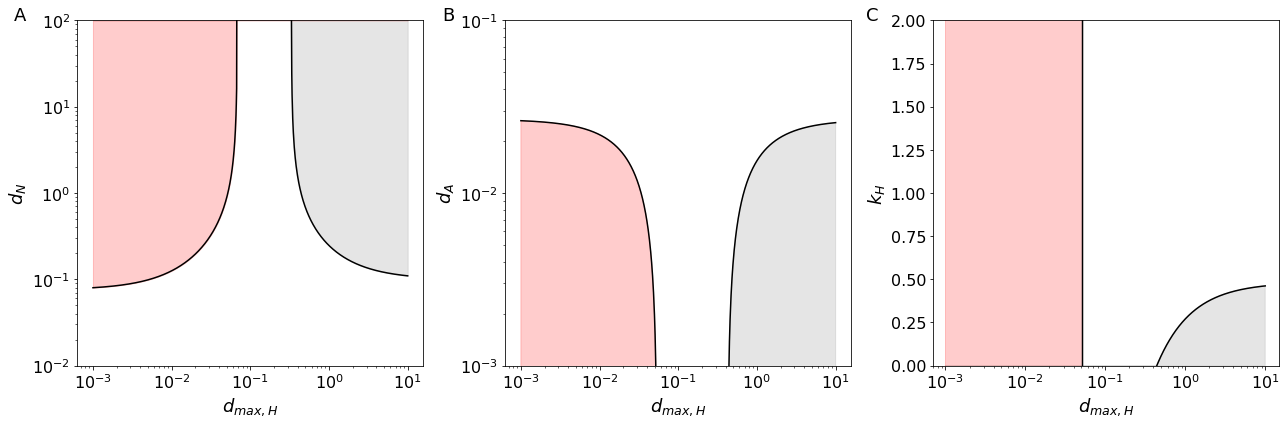

In [12]:
fig = plt.figure(figsize=(18,6))

ax1 = plt.subplot2grid((1,3),(0,0))

plt.loglog(dSvals,dNvals1,'k')
plt.loglog(dSvals,dNvals2,'k')

plt.fill_between(dSvals, dNvals1, 100, color='grey', alpha='0.2')
plt.fill_between(dSvals, dNvals2, 100, color='red', alpha='0.2')
plt.text(1e-4,1e2,'A',fontsize=18)
plt.ylim(1e-2,1e2)
plt.xlabel(r'$d_{max,H}$',fontsize=18)
plt.ylabel(r'$d_{N}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = plt.subplot2grid((1,3),(0,1))

plt.loglog(dSvals,dAvals1,'k')
plt.loglog(dSvals,dAvals2,'k')

plt.fill_between(dSvals, dAvals1, 0, color='grey', alpha='0.2')
plt.fill_between(dSvals, dAvals2, 0, color='red', alpha='0.2')
plt.text(1e-4,1e-1,'B',fontsize=18)
plt.ylim(1e-3,1e-1)
plt.xlabel(r'$d_{max,H}$',fontsize=18)
plt.ylabel(r'$d_{A}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax3 = plt.subplot2grid((1,3),(0,2))

plt.plot(dSvals,kvals1,'k')
plt.plot(dSvals2,kvals2,'k')

plt.fill_between(dSvals,kvals1,0, color='grey', alpha='0.2')
plt.fill_between([1e-3,0.0515],[0,0],100, color='red', alpha='0.2')
plt.text(1e-4,2,'C',fontsize=18)

ax3.set_xscale('log')
plt.xlim(0.0007,15)
plt.ylim(0,2)
plt.xlabel(r'$d_{max,H}$',fontsize=18)
plt.ylabel(r'$k_{H}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig('Figure_S4.png',dpi=300)

## Fig. S5: dominant eigenvalue(s) as a function of $d_{max,H}$

In [13]:
def sorted_eigenvalues():
    dH_vals = np.logspace(-3,1,10000)

    EV1 = []
    EV2 = []
    EV3 = []

    for dH in dH_vals:
        EVs = eig(T_mat(dN,dA,dH,0))[0]

        EV1.append(EVs[0])
        EV2.append(EVs[1])
        EV3.append(EVs[2])
        
    dH_1 = []
    dH_2 = []

    EV1_1 = []
    EV2_2 = []

    len = np.shape(dH_vals)[0]

    for i in range(len):
        if np.imag(EV3[i]) != 0:
            dH_1.append(dH_vals[i])
            EV1_1.append(np.real(EV3[i]))

        else:
            dH_2.append(dH_vals[i])
            EV2_2.append(max(np.real(EV1[i]),np.real(EV2[i]))) 
            
    return dH_1,dH_2, EV1_1, EV2_2

In [14]:
aS = 0.8
N_star, A_star, S_star = FP()
dH_1_08,dH_2_08, EV1_1_08, EV2_2_08 = sorted_eigenvalues()

aS = 1
N_star, A_star, S_star = FP()
dH_1_1,dH_2_1, EV1_1_1, EV2_2_1 = sorted_eigenvalues()

aS = 1.2
N_star, A_star, S_star = FP()
dH_1_12,dH_2_12, EV1_1_12, EV2_2_12 = sorted_eigenvalues()

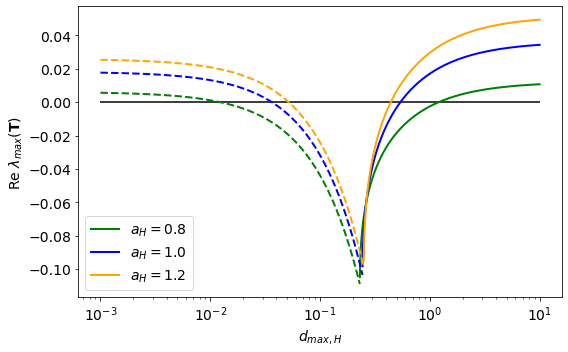

In [15]:
plt.figure(figsize=(8,5))        
        
plt.semilogx(dH_1_08,EV1_1_08,'g--',linewidth=2)
plt.semilogx(dH_2_08,EV2_2_08,'g-',linewidth=2,label=r"$a_H=0.8$")

plt.semilogx(dH_1_1,EV1_1_1,'b--',linewidth=2)
plt.semilogx(dH_2_1,EV2_2_1,'b-',linewidth=2,label=r"$a_H=1.0$")

plt.semilogx(dH_1_12,EV1_1_12,'--',color='orange',linewidth=2)
plt.semilogx(dH_2_12,EV2_2_12,'-',color='orange',linewidth=2,label=r"$a_H=1.2$")

plt.hlines(0,1e-3,10,'k')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'$d_{max,H}$',fontsize=14)
plt.ylabel(r"Re $\lambda_{max} (\mathbf{T})$",fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Figure_S5.png',dpi=300)
plt.show();

## Fig. S9: coexistence under environmental heterogeneity at small $d_{max,I}$

In [16]:
aS = 1.5
aI = 1.3
dSmax = 1
dImax = 0.001
dN = 1
dA = 0.001
kI = 0
kS = 0

t = np.linspace(0, 1000, 10000)

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.2,0.2,0,0]
X = odeint(model, x0, t,tfirst=True)  
Seff_x = S + dN*(X[-1,1]-X[-1,0])/D
Seff_y = S - dN*(X[-1,1]-X[-1,0])/D

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.2,0.2,0.1,0.1]
X = odeint(model_static_env_het, x0, t,tfirst=True) 

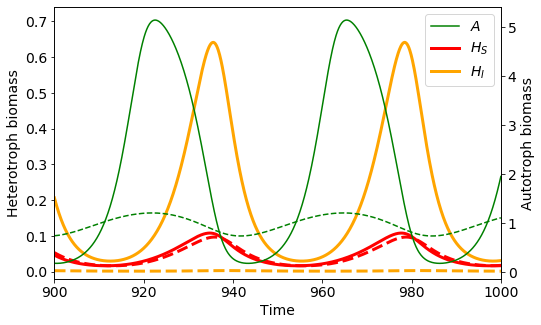

In [19]:
fig, ax = plt.subplots(figsize=(8,5))        

ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Heterotroph biomass', fontsize='14')
ax.set_xlim(900,1000)
ax.set_ylim(-0.02,0.74)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=14)
ax2.plot(t,X[:,2],'g-')
ax2.plot(t,X[:,3],'g--')
ax2.set_ylabel('Autotroph biomass', fontsize='14')  # we already handled the x-label with ax2

ax.plot(t,X[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax.plot(t,X[:,4],'r-',linewidth=3,label=r'$H_S$')
ax.plot(t,X[:,5],'r--',linewidth=3)
ax.plot(t,X[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax.plot(t,X[:,7],'--',linewidth=3,color='orange')

ax.legend(fontsize=14)

plt.savefig('Figure_S9.png',dpi=300)
plt.show()